# Estimation of level sets with BoTorch

following the entry level tutorial here https://botorch.org but I have also browsed extensively along Bite-sized and full-loop tutorials

## 1. Low dimension / low data (no fancy sampling)

Problem in 1-d: $f_{BlackBox}(x) = sin(7*x) $ at threshold $t=0.25$

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import Tensor
from botorch.utils import standardize

#true toy function
def f(x: Tensor):
    return torch.sin(7*x)

#threshold
t = 0.25

#generate truth data
true_x = torch.arange(0, 1, 0.01).double()
true_y = f(true_x).double()

#generate std training data
train_x = torch.rand(2,1).double()
train_y = f(train_x).double()
train_y_std = standardize(train_y).double()

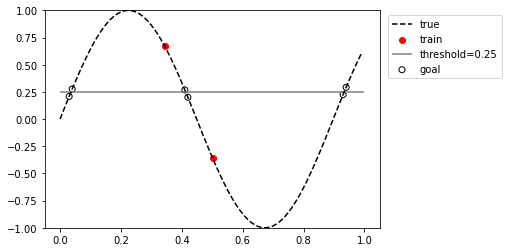

In [2]:
# helper function
from typing import Optional
def make_plot(mean: Optional=None, std: Optional=None, new_x: Optional=None):
    if mean is not None:
        plt.plot(true_x.detach().numpy(), mean, color='blue', label='mean');
    if std is not None:
        plt.fill_between(true_x.detach().numpy(), mean-std, mean+std, color='lightblue', label='std');
    if new_x is not None:
        plt.scatter(new_x.detach().numpy(), f(new_x).detach().numpy(), color='red', marker='o')
        plt.vlines(new_x.detach().numpy(),np.max(true_y.detach().numpy()),np.min(true_y.detach().numpy()), color='grey', linewidth=1)

    plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
    plt.scatter(train_x.detach().numpy(), train_y.detach().numpy(), color='red', marker='o', label='train')
    plt.hlines(t, 0, 1, color='grey', label=f'threshold={t}');
    plt.ylim([-1,1])
    mask = (torch.abs(true_y-t) < 0.5*10E-2).nonzero()
    plt.scatter(true_x[mask].detach().numpy(), f(true_x[mask]).detach().numpy() , color='black', marker='o', label='true LS', facecolors='none')
    lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    
make_plot()

In [3]:
#train model 
from botorch.models import FixedNoiseGP
from botorch import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

#helper function
def init_model(train_x: Tensor , train_y: Tensor, state_dict=None):
    noise = torch.full_like(train_y, 0.)
    gp = FixedNoiseGP(train_x, train_y, noise);
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
    if state_dict is not None:
        gp.load_state_dict(state_dict)
    return gp, mll
    
gp, mll = init_model(train_x, train_y)

In [4]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.objective import ScalarizedObjective
from botorch.models.model import Model
import math

#helper function
def cdf(mu, sigma, t):
    mu_reshape = torch.stack([mu,mu], dim=1)
    sigma_reshape = torch.stack([sigma, sigma], dim=1)
    erf = torch.erf((t - mu_reshape) * (sigma_reshape).reciprocal() / math.sqrt(2))
    cdf = 0.5 * (1 + erf)
    return cdf 


class MaximumEntropySearch(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        threshold: Tensor,
        objective: Optional[ScalarizedObjective] = None,
        maximize: bool = True,
    ) -> None:
        super().__init__(model=model, objective=objective)
        # self.maximize = maximize
        self.thr = threshold
        infty = 1E10
        self.thresholds = [-infty] + self.thr.tolist() + [infty]
        self.pairs_thresholds = list(zip(self.thresholds, self.thresholds[1:]))
        self.pairs_thresholds = [torch.Tensor(pair) for pair in self.pairs_thresholds]

    def forward(self, X: Tensor):
        posterior = self._get_posterior(X=X)
        batch_shape = X.shape[:-2]
        mean = posterior.mean.view(batch_shape).double()
        std = torch.square(posterior.variance.view(batch_shape).double())
        #probability of image being between thresholds
        p = cdf(mean, std, self.pairs_thresholds[1]) - cdf(mean, std, self.pairs_thresholds[0])
        probs = torch.cat([p, 1-p])
        #create bernoulli distribution
        distr = torch.distributions.Categorical(probs)
        #entropy
        entropy = distr.entropy().view(-1)
        return entropy

Suggestion iteration 1: x_new = 1.0


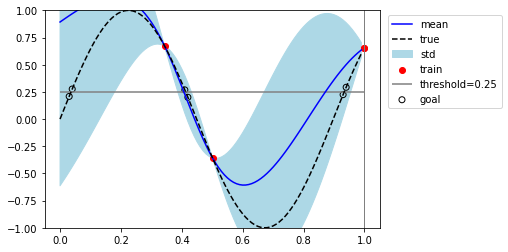

/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


Suggestion iteration 2: x_new = 0.8411992882862345


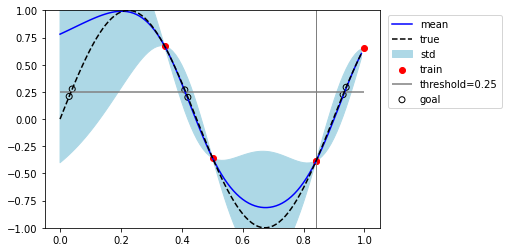

Suggestion iteration 3: x_new = 0.3860916495323181


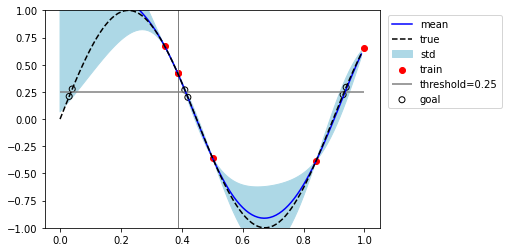

Suggestion iteration 4: x_new = 0.7288072109222412


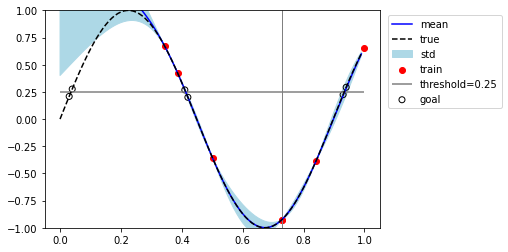

Suggestion iteration 5: x_new = 0.9424540400505066


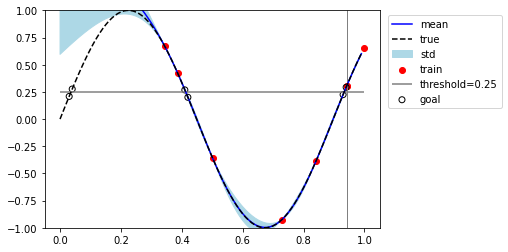

Suggestion iteration 6: x_new = 0.3610208034515381


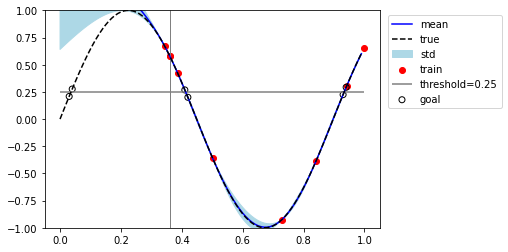

Suggestion iteration 7: x_new = 0.039261430501937866


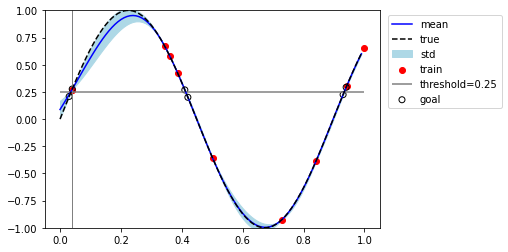

Suggestion iteration 8: x_new = 0.8887813687324524


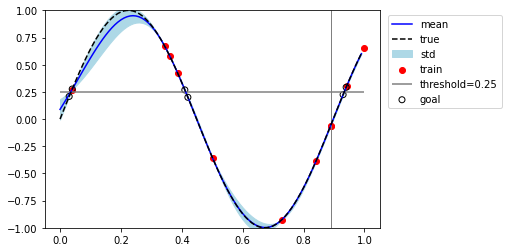

Suggestion iteration 9: x_new = 0.28436538577079773


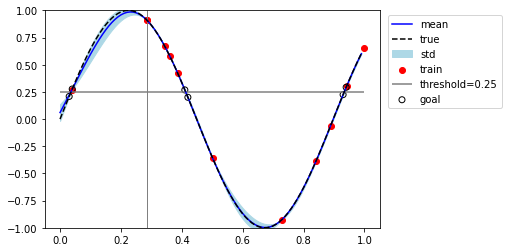

Suggestion iteration 10: x_new = 0.30993467569351196


/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


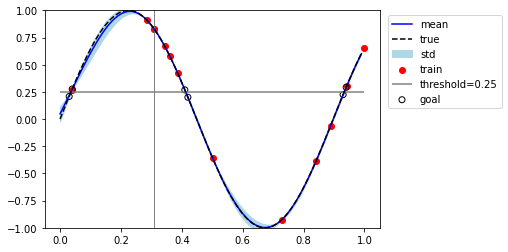

Suggestion iteration 11: x_new = 0.33147603273391724


/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


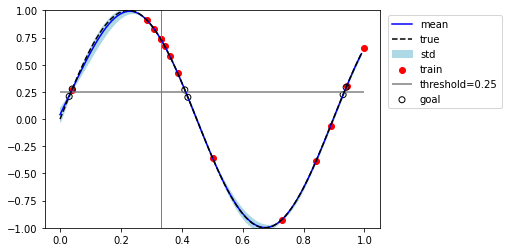

Suggestion iteration 12: x_new = 0.43529289960861206


/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


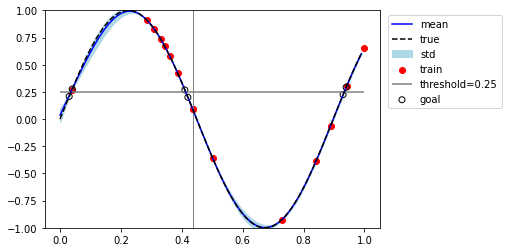

Suggestion iteration 13: x_new = 0.43134215474128723


/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


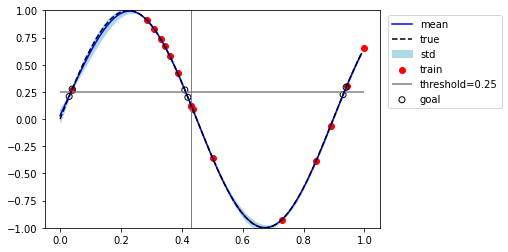

Suggestion iteration 14: x_new = 0.8023877739906311


/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


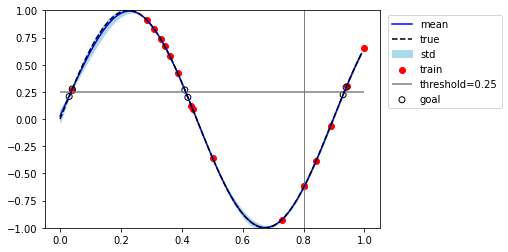

Suggestion iteration 15: x_new = 0.43782925605773926


/home/irina/.virtualenvs/lse/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


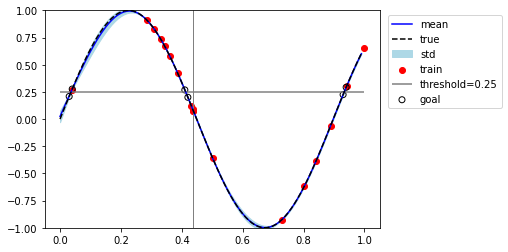

In [5]:
from botorch.optim import optimize_acqf
import numpy as np

bounds = torch.stack([torch.zeros(1), torch.ones(1)]).double()
threshold = torch.Tensor([t]) 
threshold.requires_grad=True
N_TRIALS = 15
N_Q = 1
N_RESTART = 1
N_SAMPLES = 1 

for i in range(1, N_TRIALS+1):
    
    fit_gpytorch_model(mll)
    
    #find suggestions
    MES = MaximumEntropySearch(gp, threshold=threshold)
    
    candidate, _ = optimize_acqf(
        MES, bounds=bounds, q=N_Q, num_restarts=N_RESTART, raw_samples=N_SAMPLES,
    )
    print(f"Suggestion iteration {i}: x_new = {candidate.item()}")
    
    #update training set
    train_x = torch.vstack([train_x, candidate[0]])
    train_y = torch.vstack([train_y, f(candidate[0])])
    
    #update fit
    gp, mll = init_model(train_x, train_y, gp.state_dict())    
    
    #plot fit
    mean = gp.posterior(true_x).mean.detach().numpy().flatten()
    std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())
    make_plot(mean=mean, std=std, new_x = candidate)
    plt.show()